<img src="images/arm_logo.png" width=500 alt="ARM Logo"></img>

# Bankhead National Forest - SACR RHI Investigation

## Overview

As a part of standard quality control procedures for ARM radars, one system is typically matched to another for cross-comparison of specific parameters (e.g. reflectivity, differential reflectivity, etc). 

As a standard procedure for the Ka-band Scanning Arm Cloud Radar (Ka-SACR), columns from the range height indictator (RHI) scans over the Ka-band Zenith Radar (KAZR) are extracted for comparison. 

Investigation into the column extraction from a RHI scan has been requested.

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy/) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf) | Helpful | Familiarity with metadata structure |
| [GeoPandas](https://geopandas.org/en/stable/docs.html) | Necessary | Familiarity with Geospatial Plotting|
| [Py-ART / Radar Foundations](https://projectpythia.org/radar-cookbook/) | Necessary | Basics of Weather Radar | 

- **Time to learn**: 30 minutes

## BNF Site Locations
| Site  | Lat   | Lon   |
| ----- | ----- | ----- |
| M1    | 34.34525 | -87.33842 |
| S4    | 34.46451 | -87.23598 |
| S20   | 34.65401 | -87.29264 |
| S30   | 34.38501 | -86.92757 |
| S40   | 34.17932 | -87.45349 |
| S10.  | 34.34361 | -87.35027 |
| S13.  | 34.34388 | -87.35055 |
| S14.  | 34.34333 | -87.35083 |

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import glob
import os
import datetime
import tempfile
from datetime import timedelta

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import xarray as xr
import pandas as pd
import dask
import cartopy
import cartopy.crs as ccrs

from math import atan2 as atan2
from cartopy import crs as ccrs, feature as cfeature
from cartopy.io.img_tiles import OSM
from matplotlib.transforms import offset_copy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axisartist.grid_finder import FixedLocator, DictFormatter
from matplotlib import colors
from dask.distributed import Client, LocalCluster
from metpy.plots import USCOUNTIES
from PIL import Image
from scipy.signal import find_peaks

import act
import pyart
import wradlib as wrl
import cmweather
import xradar as xd

dask.config.set({'logging.distributed': 'error'})


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Define Functions

In [2]:
def subset_points(nfile, **kwargs):
    """
    Subset a radar file for a set of latitudes and longitudes
    utilizing Py-ART's get_field_location functionality.

    Parameters
    ----------
    file : str
        Path to the radar file to extract columns from
    nsonde : list
        List containing file paths to the desired sonde file to merge

    Calls
    -----
    radar_start_time
    merge_sonde

    Returns
    -------
    ds : xarray DataSet
        Xarray Dataset containing the radar column above a give set of locations
    
    """
    ds = None
    
    # Define the splash locations [lon,lat]
    M1 = [34.34525, -87.33842]
    S13 = [34.343889, -87.350556]

    sites    = ["M1", "S13"]
    site_alt = [293, 286]

    # Zip these together!
    lats, lons = list(zip(M1,
                          S13))
    try:
        # Read in the file
        radar = pyart.io.read(nfile)
        # Check for single sweep scans
        if np.ma.is_masked(radar.sweep_start_ray_index["data"][1:]):
            radar.sweep_start_ray_index["data"] = np.ma.array([0])
            radar.sweep_end_ray_index["data"] = np.ma.array([radar.nrays])
    except:
        radar = None

    if radar:
        if radar.scan_type != "rhi":
            if radar.time['data'].size > 0:
        
                column_list = []
                for lat, lon in zip(lats, lons):
                    # Make sure we are interpolating from the radar's location above sea level
                    # NOTE: interpolating throughout Troposphere to match sonde to in the future
                    try:
                        da = (
                            pyart.util.columnsect.get_field_location(radar, lat, lon)
                            .interp(height=np.arange(500, 8500, 200))
                        )
                    except ValueError:
                        da = pyart.util.columnsect.get_field_location(radar, lat, lon)
                        # check for valid heights
                        valid = np.isfinite(da["height"])
                        n_valid = int(valid.sum())
                        if n_valid > 0:
                            da = da.sel(height=valid).sortby("height").interp(height=np.arange(500, 8500, 200))
                        else:
                            target_height = xr.DataArray(np.arange(500, 8500, 200), dims="height", name="height")
                            da = da.reindex(height=target_height)

                    # Add the latitude and longitude of the extracted column
                    da["lat"], da["lon"] = lat, lon
                    # Convert timeoffsets to timedelta object and precision on datetime64
                    ##da.time_offset.data = da.time_offset.values.astype("timedelta64[s]")
                    da.base_time.data = da.base_time.values.astype("datetime64[s]")
                    column_list.append(da)
        
                # Concatenate the extracted radar columns for this scan across all sites    
                ds = xr.concat([data for data in column_list if data], dim='station')
                ds["station"] = sites
                # Assign the Main and Supplemental Site altitudes
                ds = ds.assign(alt=("station", site_alt))
                ds.station.attrs.update(long_name="Bankhead National Forest AMF-3 In-Situ Ground Observation Station Identifers")
                ds.lat.attrs.update(long_name='Latitude of BNF AMF-3 Ground Observation Site',
                                         units='Degrees North')
                ds.lon.attrs.update(long_name='Longitude of BNF AMF-3 Ground Observation Site',
                                          units='Degrees East')
                ds.alt.attrs.update(long_name="Altitude above mean sea level for each station",
                                          units="m")
                # delete the radar to free up memory
                del radar, column_list, da
            else:
                # delete the rhi file
                del radar
        else:
            del radar
    return ds

In [3]:
def gc_latlon_bear_dist(lat1, lon1, bear, dist):
    """
    Input lat1/lon1 as decimal degrees, as well as bearing and distance from
    the coordinate. Returns lat2/lon2 of final destination. Cannot be
    vectorized due to atan2.
    """
    re = 6371.1  # km
    lat1r = np.deg2rad(lat1)
    lon1r = np.deg2rad(lon1)
    bearr = np.deg2rad(bear)
    lat2r = np.arcsin((np.sin(lat1r) * np.cos(dist/re)) +
                      (np.cos(lat1r) * np.sin(dist/re) * np.cos(bearr)))
    lon2r = lon1r + atan2(np.sin(bearr) * np.sin(dist/re) *
                          np.cos(lat1r), np.cos(dist/re) - np.sin(lat1r) *
                          np.sin(lat2r))
    return np.rad2deg(lat2r), np.rad2deg(lon2r)
 
    
def add_scale_line(scale, ax, projection, color='k',
                  linewidth=None, fontsize=None, fontweight=None):
    """
    Adds a line that shows the map scale in km. The line will automatically
    scale based on zoom level of the map. Works with cartopy.
 
    Parameters
    ----------
    scale : scalar
        Length of line to draw, in km.
    ax : matplotlib.pyplot.Axes instance
        Axes instance to draw line on. It is assumed that this was created
        with a map projection.
    projection : cartopy.crs projection
        Cartopy projection being used in the plot.
 
    Other Parameters
    ----------------
    color : str
        Color of line and text to draw. Default is black.
    """
    frac_lat = 0.1  # distance fraction from bottom of plot
    frac_lon = 0.5  # distance fraction from left of plot
    e1 = ax.get_extent()
    center_lon = e1[0] + frac_lon * (e1[1] - e1[0])
    center_lat = e1[2] + frac_lat * (e1[3] - e1[2])
    # Main line
    lat1, lon1 = gc_latlon_bear_dist(
        center_lat, center_lon, -90, scale / 2.0)  # left point
    lat2, lon2 = gc_latlon_bear_dist(
        center_lat, center_lon, 90, scale / 2.0)  # right point
    if lon1 <= e1[0] or lon2 >= e1[1]:
        warnings.warn('Scale line longer than extent of plot! ' +
                      'Try shortening for best effect.')
    ax.plot([lon1, lon2], [lat1, lat2], linestyle='-',
            color=color, transform=projection, 
            linewidth=linewidth)
    # Draw a vertical hash on the left edge
    lat1a, lon1a = gc_latlon_bear_dist(
        lat1, lon1, 180, frac_lon * scale / 20.0)  # bottom left hash
    lat1b, lon1b = gc_latlon_bear_dist(
        lat1, lon1, 0, frac_lon * scale / 20.0)  # top left hash
    ax.plot([lon1a, lon1b], [lat1a, lat1b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw a vertical hash on the right edge
    lat2a, lon2a = gc_latlon_bear_dist(
        lat2, lon2, 180, frac_lon * scale / 20.0)  # bottom right hash
    lat2b, lon2b = gc_latlon_bear_dist(
        lat2, lon2, 0, frac_lon * scale / 20.0)  # top right hash
    ax.plot([lon2a, lon2b], [lat2a, lat2b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw scale label
    ax.text(center_lon, center_lat - frac_lat * (e1[3] - e1[2]) / 3.0,
            str(int(scale)) + ' km', horizontalalignment='center',
            verticalalignment='center', color=color, fontweight=fontweight,
            fontsize=fontsize)

In [4]:
def bnf_display(radar,
                field="reflectivity", 
                vmin=-40, 
                vmax=5):
    """
    Create a display to visualize radar reflectivity across
    the domain, marking locations of the BNF sites. 

    Input
    -----
    radar : str
        Path to radar file
    field : str
        Specific radar parameter to display
    vmin : int
        Minimum value to display between all subplots for the specific radar
        parameter
    vmax : int
        Maximum value to display between all subplots for the specific radar
        parameter

    Returns
    -------
    fig : matplotlib figure
        returns a figure object for display
    """

    #------------------
    # Inputs
    #------------------
    
    # Open the files
    try:
        radar = pyart.io.read(radar)
        # skip the RHI scans for now
        if radar.scan_type != "ppi":
            print("rhi file")
            return
        # check for those weird files
        if radar.elevation['data'].shape[0] < 1:
            return
    except:
        return

    # define the sites of interest
    nsite = {"M1" : [34.34525, -87.33842],
             "S4" : [34.46451, -87.23598],
             "S3" : [34.63080, -87.13311],
             "S20" : [34.65401, -87.29264]}

    # define the center of the map to be the CSAPR2
    central_lon = -87.13076
    central_lat = 34.63080

    #-------------------
    # Define the Figure 
    #-------------------

    fig = plt.figure(figsize=(16, 8))
    tiler = OSM()
    mercator = tiler.crs

    #--------------------------------------
    # Main Plot - Display the CMAC Field
    #--------------------------------------
    # Create a subplot and define projection
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

    # Add some various map elements to the plot to make it recognizable.
    ax.add_feature(cfeature.COASTLINE)
    ax.add_image(tiler, 9, zorder=2, alpha=0.35)
    # Set the BNF Domain (adjust later for various groups)
    ax.set_extent([272.5, 273.0, 34.7, 34.2])
    gl = ax.gridlines(draw_labels=True)
    # Hide the right side ticks
    ax.tick_params(labeltop=False, labelright=False)

    # Add the column sites
    markers = ["p", "*", "+", "D", "o", "s"]
    for i, site in enumerate(nsite):
            ax.scatter(nsite[site][1],
                       nsite[site][0],
                       marker=markers[i],
                       color="black",
                       s=75,
                       label=site,
                       zorder=3,
                       transform=ccrs.PlateCarree())
        
            # Use the cartopy interface to create a matplotlib transform object
            # for the Geodetic coordinate system. We will use this along with
            # matplotlib's offset_copy function to define a coordinate system which
            # translates the text by 25 pixels to the left.
            # note - taken from cartopy examples
            geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax)
            text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)

            if site == "S3":
                # Add text 25 pixels to the left of the volcano.
                ax.text(nsite[site][1]-0.01, 
                        nsite[site][0], 
                        "CSAPR-2", 
                        verticalalignment='center', 
                        horizontalalignment='right', 
                        transform=text_transform,
                        bbox=dict(facecolor='sandybrown', 
                        alpha=0.5, 
                        boxstyle='round'))
            else:
                # Add text 25 pixels to the left of the volcano.
                ax.text(nsite[site][1]-0.01, 
                        nsite[site][0], 
                        site, 
                        verticalalignment='center', 
                        horizontalalignment='right', 
                        transform=text_transform,
                        bbox=dict(facecolor='sandybrown', 
                        alpha=0.5, 
                        boxstyle='round'))

    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi_map(field,  
                         vmin=vmin, 
                         vmax=vmax,
                         ax=ax,
                         cmap="ChaseSpectral",
                         zorder=1,
                         colorbar_flag=False,
                        )

    ims = display.plots[0]
    cbar = fig.colorbar(ims, ax=ax, location="bottom", shrink=0.6, pad=0.1)
    cbar_label = (radar.fields["reflectivity"]["long_name"] +  
                 '\n [' + 
                 radar.fields["reflectivity"]["units"] + ']'
    )
    cbar.set_label(cbar_label)

    # Add our scale bar
    add_scale_line(20.0, ax, projection=ccrs.PlateCarree(), 
                   color='black', linewidth=3,
                   fontsize=12,
                   fontweight='bold')
    
    return fig


## Read the Ka-SACR Data with `xradar`

In [5]:
# Define the desired processing date for the BNF CSAPR-2 in YYYY-MM-DD format.
DATE = "20250425"
# Define the directory where the BNF CSAPR-2 CMAC files are located.
RADAR_DIR = sorted(glob.glob(os.getenv("BNF_SACR_DIR") + "*." + DATE + ".*.nc"))

### Initial Look at the Data

In [6]:
dt = xd.io.open_cfradial1_datatree(RADAR_DIR[1])

In [7]:
dt

<xarray.DataTree>
Group: /
│   Dimensions:              (sweep: 4, frequency: 1)
│   Coordinates:
│     * frequency            (frequency) float32 4B 3.529e+10
│   Dimensions without coordinates: sweep
│   Data variables:
│       sweep_fixed_angle    (sweep) float32 16B ...
│       instrument_type      |S22 22B ...
│       platform_type        |S22 22B ...
│       primary_axis         |S22 22B ...
│       sweep_group_name     (sweep) <U9 144B 'sweep_0.0' ... 'sweep_3.0'
│       time_coverage_end    |S22 22B ...
│       time_coverage_start  |S22 22B ...
│       volume_number        float64 8B ...
│       latitude             float32 4B ...
│       longitude            float32 4B ...
│       altitude             float32 4B ...
│       altitude_agl         float32 4B ...
│   Attributes:
│       Conventions:      ARM-1.3 CF/Radial-1.4 instrument_parameters radar_param...
│       title:            ARM KaSACR1 Moments
│       institution:      U.S. Department of Energy Atmospheric Radiation Measure...
│       references:       See Instrument Handbook
│       comment:          Number of samples changes per variable. See Handbook.
│       instrument_name:  KaSACR-1
│       scan_name:        ppiv
│       site_name:        bnfS4
│       source:           SACR software version: 1.10.115
│       history:          created by user dsmgr on machine prod-proc4.adc.arm.gov...
├── Group: /radar_parameters
│       Dimensions:               ()
│       Data variables:
│           radar_antenna_gain_v  float32 4B ...
│           radar_beam_width_v    float32 4B ...
│           radar_antenna_gain_h  float32 4B ...
│           radar_beam_width_h    float32 4B ...
├── Group: /georeferencing_correction
├── Group: /radar_calibration
│       Dimensions:                ()
│       Data variables:
│           noise_hc               float32 4B ...
│           noise_source_power_h   float32 4B ...
│           noise_source_power_v   float32 4B ...
│           noise_vc               float32 4B ...
│           pulse_width            float32 4B ...
│           radar_constant_h       float32 4B ...
│           radar_constant_v       float32 4B ...
│           receiver_gain_hc       float32 4B ...
│           receiver_gain_vc       float32 4B ...
│           two_way_radome_loss_h  float32 4B ...
│           xmit_power_h           float32 4B ...
...
├── Group: /sweep_1
│       Dimensions:                             (azimuth: 377, range: 743)
│       Coordinates:
│         * azimuth                             (azimuth) float32 2kB 0.1075 ... 358.6
│         * range                               (range) float32 3kB 401.3 ... 1.894e+04
│           time                                (azimuth) datetime64[ns] 3kB 2025-04-...
│           elevation                           (azimuth) float32 2kB ...
│           latitude                            float32 4B ...
│           longitude                           float32 4B ...
│           altitude                            float32 4B ...
│       Data variables: (12/24)
│           time_offset                         (azimuth) datetime64[ns] 3kB ...
│           co_to_crosspol_correlation_coeff    (azimuth, range) float32 1MB ...
│           crosspolar_differential_phase       (azimuth, range) float32 1MB ...
│           linear_depolarization_ratio_v       (azimuth, range) float32 1MB ...
│           mean_doppler_velocity               (azimuth, range) float32 1MB ...
│           reflectivity                        (azimuth, range) float32 1MB ...
│           ...                                  ...
│           radar_measured_sky_noise_v          (azimuth) float32 2kB ...
│           radar_measured_transmit_power       (azimuth) float32 2kB ...
│           scan_rate                           (azimuth) float32 2kB ...
│           sweep_mode                          <U20 80B 'azimuth_surveillance'
│           sweep_number                        float64 8B ...
│           unambiguous_range                   (azimuth) float32 2kB

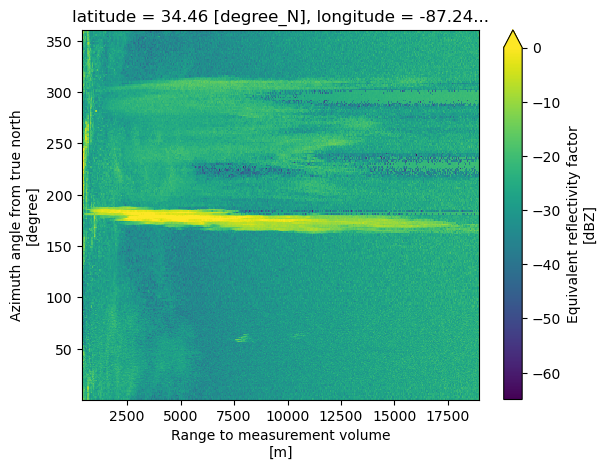

In [8]:
dt['sweep_2']['reflectivity'].plot(vmax=0)

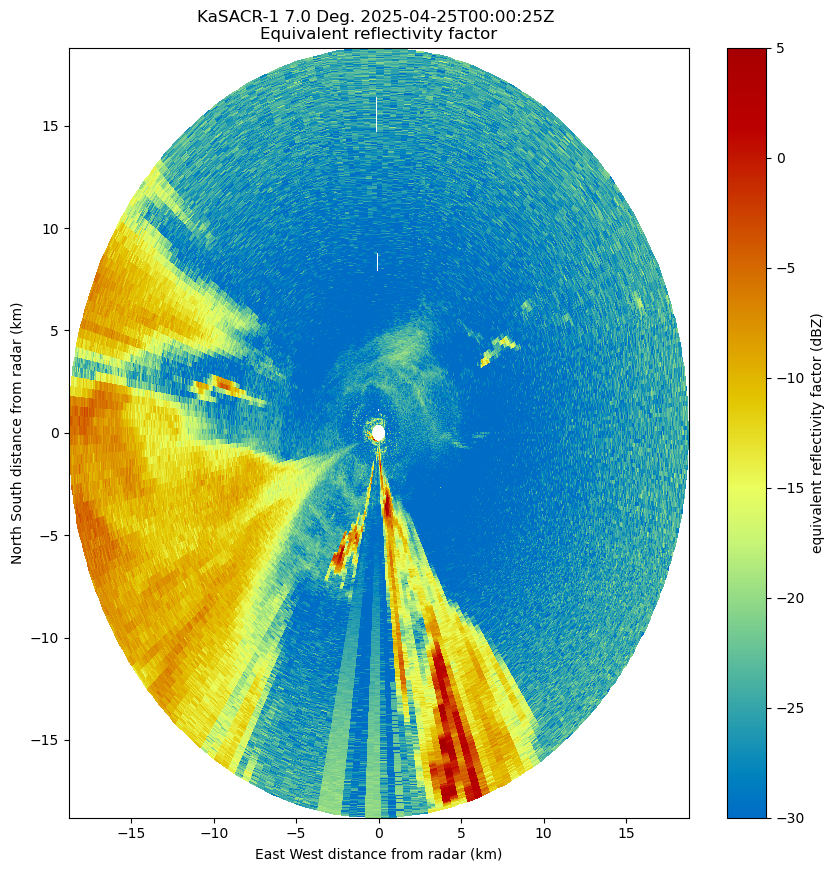

In [9]:
fig = plt.figure(figsize=[10, 10])
radar = pyart.xradar.Xradar(dt)
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi("reflectivity", vmax=5)

### Convert from `xradar` to BNF Display

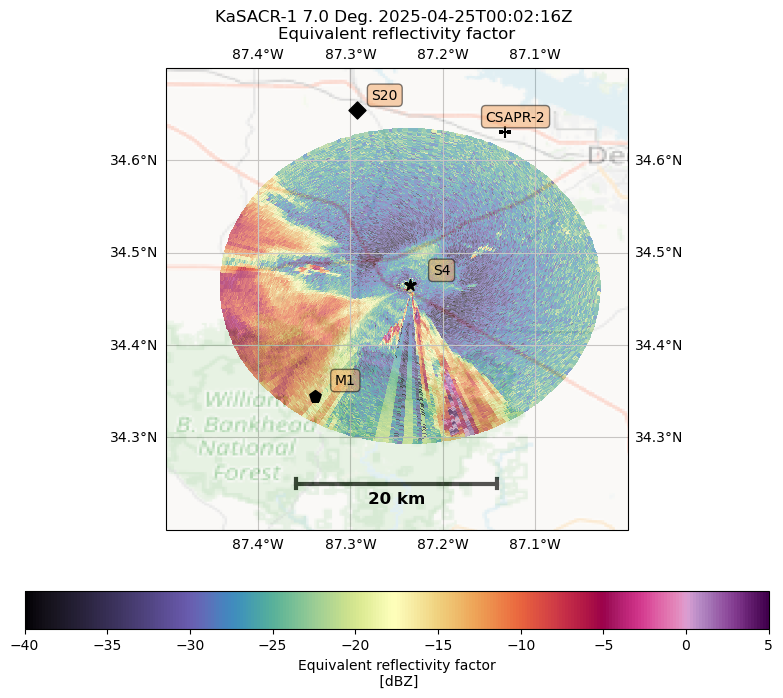

In [10]:
outfig = bnf_display(RADAR_DIR[1])

## Column Extraction

### Single Column - PPI

In [11]:
single_column = pyart.util.columnsect.get_field_location(radar, 34.34525, -87.33842)

In [12]:
single_column

<xarray.Dataset> Size: 184B
Dimensions:                             (height: 4)
Coordinates:
  * height                              (height) float32 16B 2.198e+03 ... 5....
Data variables:
    co_to_crosspol_correlation_coeff    (height) float32 16B 0.1879 ... 0.2164
    crosspolar_differential_phase       (height) float32 16B -110.1 ... -49.57
    linear_depolarization_ratio_v       (height) float32 16B -18.47 ... -3.349
    mean_doppler_velocity               (height) float32 16B -5.151 ... -4.885
    reflectivity                        (height) float32 16B -13.94 ... -28.62
    signal_to_noise_ratio_copolar_h     (height) float32 16B -4.958 ... -19.44
    signal_to_noise_ratio_crosspolar_v  (height) float32 16B -17.3 ... -17.21
    spectral_width                      (height) float32 16B 0.5371 ... 0.1177
    base_time                           datetime64[ns] 8B 2025-04-25T00:00:25...
    time_offset                         (height) datetime64[ns] 32B 2025-04-2...
Attributes:
    distance_from_radar:    16.231 km
    azimuth:                215.402 degrees
    latitude_of_location:   34.34525 degrees
    longitude_of_location:  -87.33842 degrees

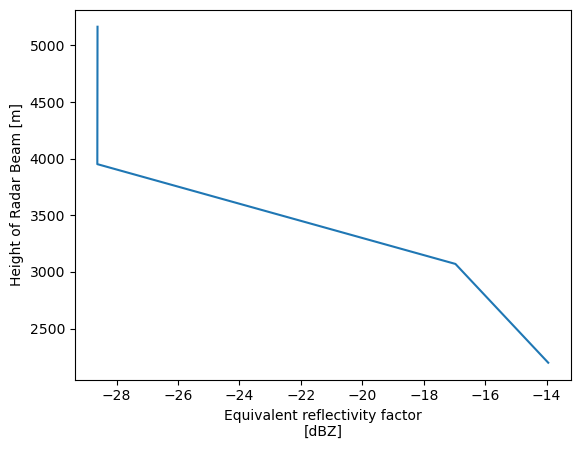

In [13]:
single_column.reflectivity.plot(y='height')

### All PPI Scans

In [14]:
%%time
## Start up a Dask Cluster
columns = []
for file in RADAR_DIR:
    columns.append(subset_points(file))

CPU times: user 1min 3s, sys: 3.07 s, total: 1min 6s
Wall time: 1min 7s


In [15]:
# Concatenate all extracted columns across time dimension to form daily timeseries
ppi = xr.concat([data for data in columns if data], dim="time")
# Drop unnecessary time dimensions from a few required ARM spatial variables
ppi['time'] = ppi.sel(station="M1").base_time
ppi['time_offset'] = ppi.sel(station="M1").base_time
ppi['base_time'] = ppi.sel(station="M1").isel(time=0).base_time
ppi['lat'] = ppi.isel(time=0).lat
ppi['lon'] = ppi.isel(time=0).lon
ppi['alt'] = ppi.isel(time=0).alt

In [16]:
ppi

<xarray.Dataset> Size: 2MB
Dimensions:                             (time: 480, station: 2, height: 40)
Coordinates:
  * time                                (time) datetime64[s] 4kB 2025-04-25T0...
  * station                             (station) <U3 24B 'M1' 'S13'
  * height                              (height) int64 320B 500 700 ... 8300
Data variables: (12/13)
    co_to_crosspol_correlation_coeff    (time, station, height) float64 307kB ...
    crosspolar_differential_phase       (time, station, height) float64 307kB ...
    linear_depolarization_ratio_v       (time, station, height) float64 307kB ...
    mean_doppler_velocity               (time, station, height) float64 307kB ...
    reflectivity                        (time, station, height) float64 307kB ...
    signal_to_noise_ratio_copolar_h     (time, station, height) float64 307kB ...
    ...                                  ...
    spectral_width                      (time, station, height) float64 307kB ...
    base_time                           datetime64[s] 8B 2025-04-25T00:00:01
    lat                                 (station) float64 16B 34.35 34.34
    lon                                 (station) float64 16B -87.34 -87.35
    alt                                 (station) int64 16B 293 286
    time_offset                         (time) datetime64[s] 4kB 2025-04-25T0...
Attributes:
    distance_from_radar:    16.231 km
    azimuth:                215.402 degrees
    latitude_of_location:   34.34525 degrees
    longitude_of_location:  -87.33842 degrees

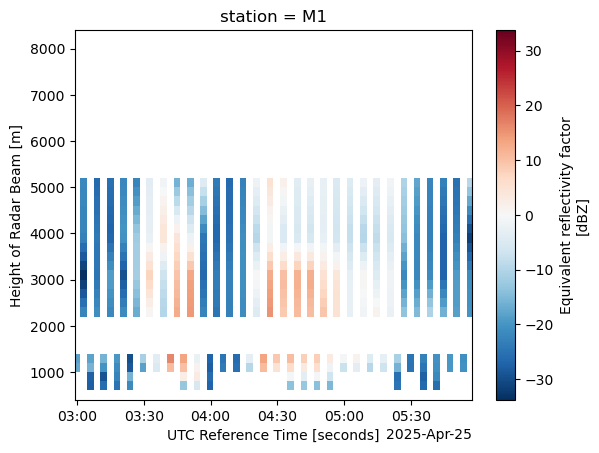

In [17]:
ppi.sel(station="M1").sel(time=slice("2025-04-25T03:00:00", "2025-04-25T06:00:00")).reflectivity.plot(x='time')

### Single Column - RHI

In [18]:
radar_rhi = pyart.io.read(RADAR_DIR[2])
radar_rhi.scan_type

'rhi'

In [19]:
display = pyart.graph.RadarDisplay(radar_rhi)

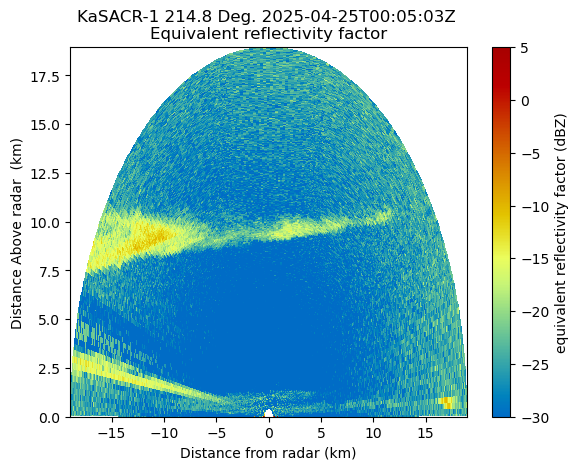

In [20]:
display.plot("reflectivity", vmax=5)

In [21]:
rhi_column = pyart.util.columnsect.get_field_location(radar_rhi, 34.34525, -87.33842)

In [22]:
rhi_column

<xarray.Dataset> Size: 18kB
Dimensions:                             (height: 379)
Coordinates:
  * height                              (height) float64 3kB 503.1 ... 355.7
Data variables:
    co_to_crosspol_correlation_coeff    (height) float32 2kB 0.03368 ... 0.2503
    crosspolar_differential_phase       (height) float32 2kB 147.6 ... 54.12
    linear_depolarization_ratio_v       (height) float32 2kB -7.769 ... -3.745
    mean_doppler_velocity               (height) float32 2kB -3.81 ... -1.511
    reflectivity                        (height) float32 2kB -25.52 ... -24.84
    signal_to_noise_ratio_copolar_h     (height) float32 2kB -15.85 ... -15.29
    signal_to_noise_ratio_crosspolar_v  (height) float32 2kB -18.1 ... -13.36
    spectral_width                      (height) float32 2kB 0.2479 ... 0.3558
    base_time                           datetime64[ns] 8B 2025-04-25T00:05:01...
    time_offset                         (height) datetime64[ns] 3kB 2025-04-2...
Attributes:
    distance_from_radar:    16.231 km
    azimuth:                215.402 degrees
    latitude_of_location:   34.34525 degrees
    longitude_of_location:  -87.33842 degrees

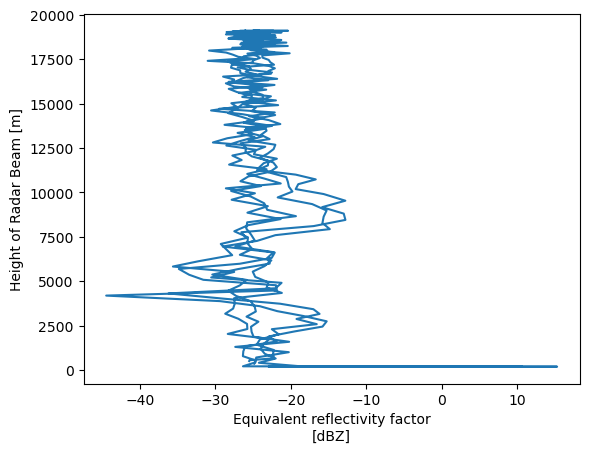

In [23]:
rhi_column.reflectivity.plot(y='height')

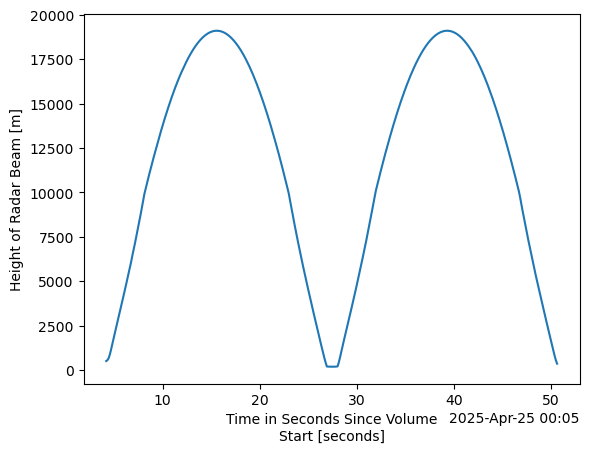

In [24]:
rhi_column.time_offset.plot(y="height")

In [25]:
def split_column(column, height_range=[500, 8500], height_interp=200):
    """
    For Extracted Columns from RHI scans, height values are not unique,
    limiting the ability to interpolate across the entire date to
    standardize gates

    Given a column, find the peaks within the distribution, and split the
    column into separate instances with unique height values

    Inputs
    ------
    column : xarray DataSet
        extracted column for a specific site
    height_range : list [min, max]
        Height Range to interpolate each column split
    height_interp : int
        Frequency between height gates used within interpolation
    
    Outputs
    -------
    split_column : list
        From the peaks (p) within the height distribution, peaks are split into
        separate columns and returned to the user as a list of xarray DataSets. 

    """

    # Determine the peaks within extracted column
    peaks, _ = find_peaks(column['height'], prominence=1)

    if len(peaks) > 1:
        # Before first peak
        column_a = column.isel(height=slice(0, peaks[0])).interp(
            height=np.arange(height_range[0], height_range[1], height_interp))
        column_a['base_time'] = column.isel(height=slice(0, peaks[0])).time_offset.data[-1]
        # First Peak to Minimium
        column_b = column.isel(height=slice(peaks[0], int(column.height.argmin()))).interp(
            height=np.arange(height_range[0], height_range[1], height_interp))
        column_b['base_time'] = column.isel(height=slice(peaks[0], int(column.height.argmin()))).time_offset.data[-1]
        # Minimum to 2nd Peak
        column_c = column.isel(height=slice(int(column.height.argmin()+1), peaks[1])).interp(
            height=np.arange(height_range[0], height_range[1], height_interp))
        column_c['base_time'] = column.isel(height=slice(int(column.height.argmin()+1), peaks[1])).time_offset.data[-1]
        # 2nd Peak to end
        column_d = column.isel(height=slice(peaks[1], len(column.height))).interp(
            height=np.arange(height_range[0], height_range[1], height_interp))
        column_d['base_time'] = column.isel(height=slice(peaks[1], len(column.height))).time_offset.data[-1]
        split_column = [column_a, column_b, column_c, column_d]
    else:
        column_a = column.isel(height=slice(0, peaks[0])).interp(
            height=np.arange(height_range[0], height_range[1], height_interp))
        column_b = column.isel(height=slice(peaks[0], int(rhi_column.height.argmin()))).interp(
            height=np.arange(height_range[0], height_range[1], height_interp))
        split_column = [column_a, column_b]

    return split_column

In [26]:
out_column = split_column(rhi_column)

In [27]:
out_column[2]

<xarray.Dataset> Size: 3kB
Dimensions:                             (height: 40)
Coordinates:
  * height                              (height) int64 320B 500 700 ... 8300
Data variables:
    co_to_crosspol_correlation_coeff    (height) float64 320B 0.247 ... 0.1469
    crosspolar_differential_phase       (height) float64 320B 86.85 ... -12.41
    linear_depolarization_ratio_v       (height) float64 320B -6.108 ... -6.619
    mean_doppler_velocity               (height) float64 320B -4.864 ... 10.22
    reflectivity                        (height) float64 320B -24.66 ... -25.79
    signal_to_noise_ratio_copolar_h     (height) float64 320B -15.61 ... -16.71
    signal_to_noise_ratio_crosspolar_v  (height) float64 320B -15.69 ... -17.96
    spectral_width                      (height) float64 320B 0.2959 ... 0.1936
    base_time                           datetime64[ns] 8B 2025-04-25T00:05:39...
Attributes:
    distance_from_radar:    16.231 km
    azimuth:                215.402 degrees
    latitude_of_location:   34.34525 degrees
    longitude_of_location:  -87.33842 degrees

In [28]:
rhi_single = xr.concat([data for data in out_column if data], dim="time")
rhi_single['time'] = rhi_single['base_time']

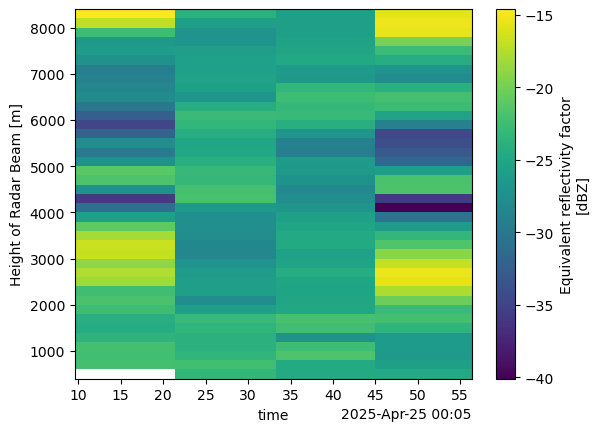

In [29]:
rhi_single.reflectivity.plot(x='time')

### All RHI Columns

In [30]:
merge_columns = []

for file in RADAR_DIR:
    radar = pyart.io.read(file)
    if radar.scan_type == "rhi":
        rhi_column = pyart.util.columnsect.get_field_location(radar, 34.34525, -87.33842)
        out_column = split_column(rhi_column)
        merge_columns.extend(out_column)
        
        del radar

In [31]:
rhi = xr.concat([data for data in merge_columns if data], dim="time")
# Drop unnecessary time dimensions from a few required ARM spatial variables
rhi['time'] = rhi.base_time

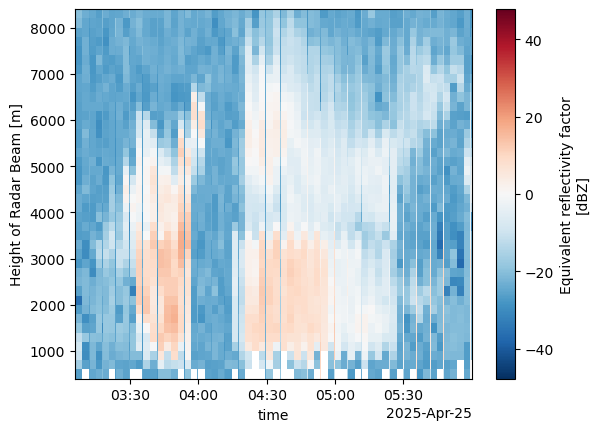

In [32]:
rhi.reflectivity.sel(time=slice("2025-04-25T03:00:00", "2025-04-25T06:00:00")).plot(y='height')

In [33]:
rhi = rhi.assign_coords(station="M1")
rhi

<xarray.Dataset> Size: 2MB
Dimensions:                             (time: 944, height: 40)
Coordinates:
  * time                                (time) datetime64[ns] 8kB 2025-04-25T...
  * height                              (height) int64 320B 500 700 ... 8300
    station                             <U2 8B 'M1'
Data variables:
    co_to_crosspol_correlation_coeff    (time, height) float64 302kB nan ... ...
    crosspolar_differential_phase       (time, height) float64 302kB nan ... ...
    linear_depolarization_ratio_v       (time, height) float64 302kB nan ... ...
    mean_doppler_velocity               (time, height) float64 302kB nan ... ...
    reflectivity                        (time, height) float64 302kB nan ... ...
    signal_to_noise_ratio_copolar_h     (time, height) float64 302kB nan ... ...
    signal_to_noise_ratio_crosspolar_v  (time, height) float64 302kB nan ... ...
    spectral_width                      (time, height) float64 302kB nan ... ...
    base_time                           (time) datetime64[ns] 8kB 2025-04-25T...
Attributes:
    distance_from_radar:    16.231 km
    azimuth:                215.402 degrees
    latitude_of_location:   34.34525 degrees
    longitude_of_location:  -87.33842 degrees

## Merged PPI + RHI Column Extraction 

In [34]:
ppi = ppi.drop_vars({"base_time", "time_offset"})

In [35]:
rhi = rhi.drop_vars({"base_time"})

In [36]:
datasets = [ds_val for ds_val in [rhi, ppi] if isinstance(ds_val, xr.Dataset)]

In [37]:
combined_column = xr.merge(datasets)

In [38]:
combined_column

<xarray.Dataset> Size: 7MB
Dimensions:                             (height: 40, time: 1424, station: 2)
Coordinates:
  * height                              (height) int64 320B 500 700 ... 8300
  * time                                (time) datetime64[ns] 11kB 2025-04-25...
  * station                             (station) <U3 24B 'M1' 'S13'
Data variables:
    co_to_crosspol_correlation_coeff    (time, height, station) float64 911kB ...
    crosspolar_differential_phase       (time, height, station) float64 911kB ...
    linear_depolarization_ratio_v       (time, height, station) float64 911kB ...
    mean_doppler_velocity               (time, height, station) float64 911kB ...
    reflectivity                        (time, height, station) float64 911kB ...
    signal_to_noise_ratio_copolar_h     (time, height, station) float64 911kB ...
    signal_to_noise_ratio_crosspolar_v  (time, height, station) float64 911kB ...
    spectral_width                      (time, height, station) float64 911kB ...
    lat                                 (station) float64 16B 34.35 34.34
    lon                                 (station) float64 16B -87.34 -87.35
    alt                                 (station) int64 16B 293 286
Attributes:
    distance_from_radar:    16.231 km
    azimuth:                215.402 degrees
    latitude_of_location:   34.34525 degrees
    longitude_of_location:  -87.33842 degrees

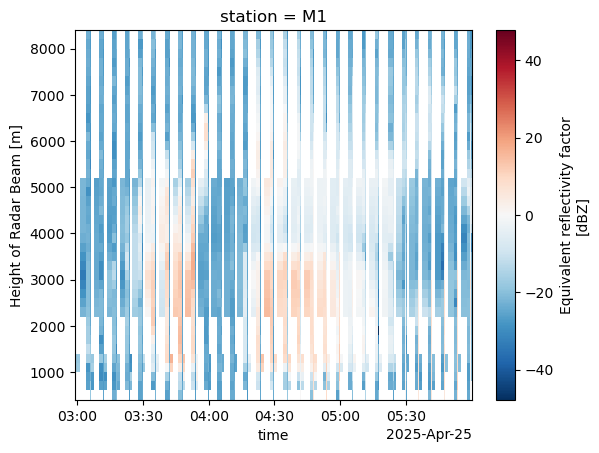

In [39]:
combined_column.sel(station="M1").sel(time=slice("2025-04-25T03:00:00", "2025-04-25T06:00:00")).reflectivity.plot(x='time')

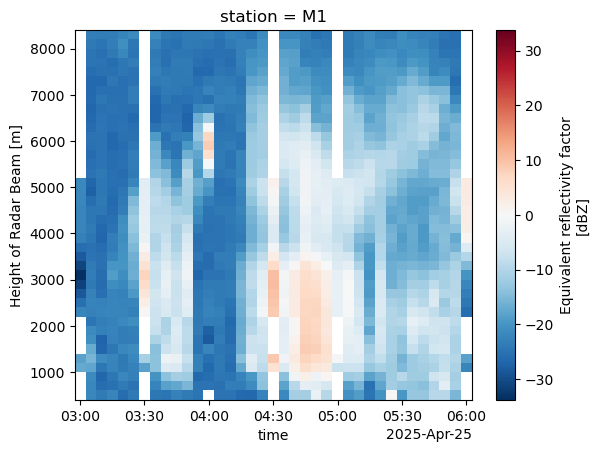

In [40]:
combined_column.resample(time="5Min").mean().sel(station="M1").sel(time=slice("2025-04-25T03:00:00", "2025-04-25T06:00:00")).reflectivity.plot(x='time')